# COMP9417 19T3  Homework 2: Applying and Implementing Machine Learning

# Question 1

## Question 1 – Learning curve 

The number of data instances required to effectively learn the target function depends on dataset characteristics and the learning algorithm. In this question, you will interpret results of learning three different datasets by two machine learning algorithms trained on varying size of data, from 5% to 90% of the dataset. After training on a fraction of the dataset, the model is tested using the rest of the dataset. For example, if 40% of data is used for training, the remaining 60% of the dataset is used for testing the trained model.
The datasets are from different, real-world  domains, and vary in size from a few hundred to a couple of thousand instances. For a smoother learning curve, the training is done in a cross validation fashion.


### Running the classifiers

**1(a). [0.5 mark]** 

Run the code section in the notebook cells below. This will generate a table of results, which you should copy and paste **WITHOUT MODIFICATION** into you report as your answer for "Question 1(a)". 

The output of the code section is a table, which represents the percentage accuracy of classification for the decision tree algorithm. Each of the columns shows accuracy for a model trained on a different fraction of the dataset.

### Result interpretation
Answer these questions in your report file.  Your answers must be based on the results table you saved in "Question 1(a)".

**1(b). [0.5 mark]** Refer to Homework2.pdf file.

**1(c). [0.5 mark]** Refer to Homework2.pdf file.

In [52]:
# Code for question 1

import numpy as np
from scipy.io import arff
import pandas as pd
from sklearn.base import TransformerMixin
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%matplotlib inline


In [53]:
# fixed random seed
np.random.seed(1)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def label_enc(labels):
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    return le

In [54]:
def load_data(path):
    dataset = arff.loadarff(path)
    data = pd.DataFrame(dataset[0])
    attr = np.array(data.columns)
    data = DataFrameImputer().fit_transform(data).values

    # mask categorical features
    masks = []
    for i in range(len(attr)-1):
        if isinstance(attr[i][1],float):
            masks.append(i)
    return data, masks

class DataFrameImputer(TransformerMixin):

    def fit(self, X, y=None):
        # Fill categorical columns with the highest frequency value, and
        # fill values columns with mean
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

def get_method_scores(data, method):
    X = data[:,0:data.shape[1]-1]
    lenc = label_enc(data[:,data.shape[1]-1])
    y = lenc.transform(data[:,data.shape[1]-1])
    train_sizes = np.array([0.05, .1, .15, .2, .25, .3, .35, .4, .45, .5])
    _, train_scores, test_scores = learning_curve(method, X, y, cv=5, 
                                                  train_sizes=train_sizes,
                                                  scoring=None, shuffle=False, random_state=0, 
                                                  error_score=0)
    return test_scores

In [55]:
# Modified to return the scores list
def test_method(method, title):
    # load data
    paths = ['australian','balance-scale','hypothyroid']
    scores = []

    for path in paths:
        score = []
        path += '.arff'
        data, masks = load_data(path)

        # training on data with different portions of training data
        score_array = get_method_scores(data, method)
        # we got a [num portions][num folds] array, need to avg them into 
        # a list of scores for each portion
        for ar in score_array:
            score.append(np.mean(ar)) # because we use 5-fold cross validation (cv=5)
        scores.append(score)

    # print the results
    method_name = method.__class__.__name__+' '+title
    header = "{:^75}".format(method_name) + '\n' + '-' * 105  + '\n' + \
    "{:^13} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} |" \
    .format("Dataset", "5%", "10%", "15%", "20%", "25%", "30%", "35%", "40%", "45%", "50%") + \
     '\n' + '-' * 105

    # print result table
    print(header)
    for i in range(len(scores)):
        print("{:<14}".format(paths[i]),end="")
        for j in range(len(scores[i])):
            print("| {:>6.2%} ".format(scores[i][j]),end="")
        print('|')
    print('\n')
    return scores

dt_scores=test_method(DecisionTreeClassifier(random_state=0),'')
ber_scores=test_method(BernoulliNB(),'with priors')
ber_no_prior_scores = test_method(BernoulliNB(fit_prior=False),'without priors')

                          DecisionTreeClassifier                           
---------------------------------------------------------------------------------------------------------
   Dataset    |   5%   |  10%   |  15%   |  20%   |  25%   |  30%   |  35%   |  40%   |  45%   |  50%   |
---------------------------------------------------------------------------------------------------------
australian    | 72.61% | 74.63% | 75.52% | 77.53% | 77.97% | 79.86% | 83.05% | 81.29% | 80.14% | 82.91% |
balance-scale | 70.10% | 72.47% | 71.20% | 75.69% | 73.77% | 75.67% | 77.74% | 75.99% | 78.09% | 76.98% |
hypothyroid   | 94.94% | 96.31% | 97.77% | 99.18% | 99.21% | 99.42% | 99.42% | 99.52% | 99.34% | 99.20% |


                          BernoulliNB with priors                          
---------------------------------------------------------------------------------------------------------
   Dataset    |   5%   |  10%   |  15%   |  20%   |  25%   |  30%   |  35%   |  40%   |  45%   |  50%   

In [56]:
def plot_cmp(dt_scores,ber_scores,label1,label2):
    paths = ['australian','balance-scale','hypothyroid']
    if(len(dt_scores)==0 or len(ber_scores)==0):
        raise ValueError('plot_all():The input list is empty')
    x_axis = np.arange(0.05,0.55,0.05)
    for i in range(len(paths)):
        plt.figure()
        plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.style.use('ggplot')
        plt.plot(x_axis,dt_scores[i],marker='o',color='blue',label=label1)
        plt.plot(x_axis,ber_scores[i],marker='o',color='red',label=label2)
        plt.yticks(np.arange(0,1.2,step=0.1))
        plt.legend()
        plt.xlabel('Training Size')
        plt.ylabel('Accuracy')
        plt.title('Learning Curve for {0}'.format(paths[i]))
        plt.savefig('{0}.png'.format(paths[i]),dpi=1000)
        plt.show()

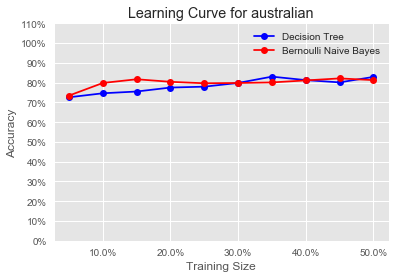

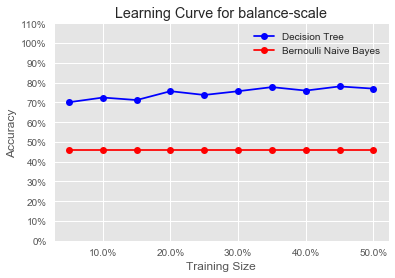

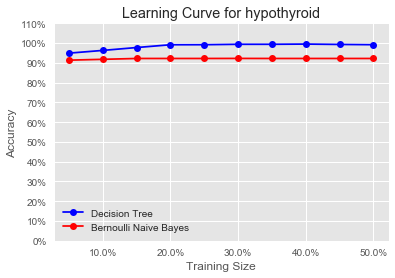

In [57]:
plot_cmp(dt_scores,ber_scores,'Decision Tree','Bernoulli Naive Bayes')

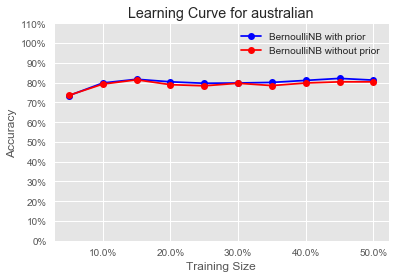

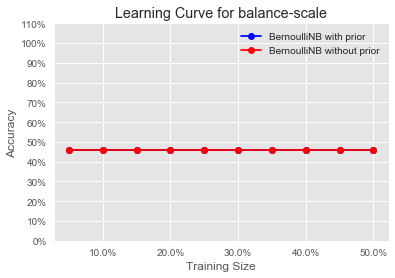

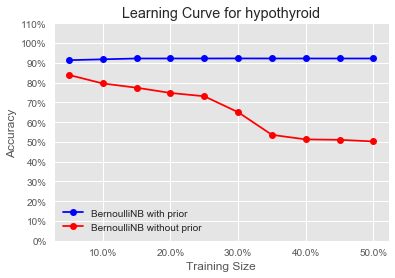

In [59]:
plot_cmp(ber_scores,ber_no_prior_scores,'BernoulliNB with prior','BernoulliNB without prior')